---
title: Identifying type I and type II FRB 
subtitle: Extending the work of [@pleunis_FastRadioBurst_2021]
author: Murthadza Aznam
date: '2023-03-20'
bibliography: references.bib
---

:::{.callout-note}

 📌 Goal: This notebook tries to differentiate between broadband and shortband single peak fast radio burst, as described in [@pleunis_FastRadioBurst_2021].

:::

In [3]:
import pandas as pd
import numpy as np
import scipy

In [100]:
from sarjana.handlers import ParquetWaterfall
from sarjana.signal import find_peaks
from pathlib import Path
import matplotlib.pyplot as plt

single_file = Path('D://', 'home', 'datasets', 'sarjana', 'raw', 'wfall', 'FRB20190117A_waterfall.h5.parquet')

burst = ParquetWaterfall(single_file).remove_rfi()

D:\home\lab\sarjana\sarjana\signal.py:40: RuntimeWarning: Degrees of freedom <= 0 for slice.
  channel_variance = np.nanvar(wfall, axis=1)
D:\home\lab\sarjana\sarjana\handlers.py:13: RuntimeWarning: Mean of empty slice
  data = np.nanmean(data.reshape((num_chan // fbin_factor, fbin_factor) + data.shape[1:]), axis=1)


In [86]:
burst.wfall_dimension

('freq', 'time')

In [142]:
from copy import deepcopy

def dmdelay(dm,fx,fstart):
    return 4148.741601*(1.0/(fstart**2)
                          -(1.0/(fx**2)))*dm

def dedisperse(data,dm,f,fstart,tsamp,sep=False):
    temp = np.zeros(data.shape)
    delay = np.round(dmdelay(dm,f,fstart)/tsamp)
    for i in range(np.shape(temp)[1]):
        temp[:,i] = np.roll(data[:,i],int(delay[i]))
    return (temp if sep else np.sum(temp,axis=1))

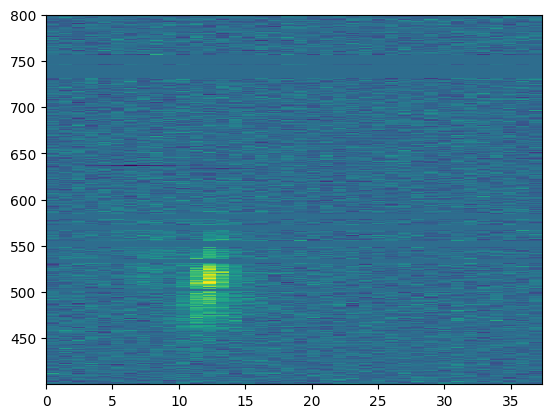

In [153]:
plt.imshow(burst.wfall, aspect="auto", interpolation="none",
                extent=burst.extent)

In [74]:
from sarjana.signal import find_full_width_nth_maximum

widths, width_heights, lefts, rights = find_full_width_nth_maximum(
            burst.ts, peaks,
             n=10
        )

widths, width_heights, lefts, rights

(array([ 3.27627544,  2.71223693, 10.60332632,  3.17391188,  1.00800037,
         7.61754665,  2.58608908,  2.71536721,  1.51370134]),
 array([ -4.12731844, -10.93771345,  -6.92809047,  29.81593574,
        -10.64009475, -16.72144703,  -3.02464486, -14.01885681,
          0.65579072]),
 array([ 3.32861646,  7.10463553, 10.15708246, 15.19890055, 21.1       ,
        23.25698313, 27.45495652, 32.18182623, 35.38629866]),
 array([ 6.6048919 ,  9.81687246, 20.76040879, 18.37281243, 22.10800037,
        30.87452978, 30.0410456 , 34.89719345, 36.9       ]))

In [75]:
np.nanmean(np.transpose(burst.model_wfall)[int(lefts[0]):int(rights[0])], axis=0)

array([4.00648365e-11, 4.00648365e-11, 4.00648365e-11, ...,
       4.00648365e-11, 4.00648365e-11, 4.00648365e-11])

D:\home\lab\sarjana\sarjana\signal.py:77: PeakPropertyWarning: some peaks have a prominence of 0
  return scipy.signal.peak_widths(y, peaks, rel_height=1 - (1 / n))
D:\home\lab\sarjana\sarjana\signal.py:77: PeakPropertyWarning: some peaks have a width of 0
  return scipy.signal.peak_widths(y, peaks, rel_height=1 - (1 / n))
D:\home\lab\sarjana\sarjana\signal.py:77: PeakPropertyWarning: some peaks have a prominence of 0
  return scipy.signal.peak_widths(y, peaks, rel_height=1 - (1 / n))
D:\home\lab\sarjana\sarjana\signal.py:77: PeakPropertyWarning: some peaks have a width of 0
  return scipy.signal.peak_widths(y, peaks, rel_height=1 - (1 / n))
D:\home\lab\sarjana\sarjana\signal.py:77: PeakPropertyWarning: some peaks have a prominence of 0
  return scipy.signal.peak_widths(y, peaks, rel_height=1 - (1 / n))
D:\home\lab\sarjana\sarjana\signal.py:77: PeakPropertyWarning: some peaks have a width of 0
  return scipy.signal.peak_widths(y, peaks, rel_height=1 - (1 / n))


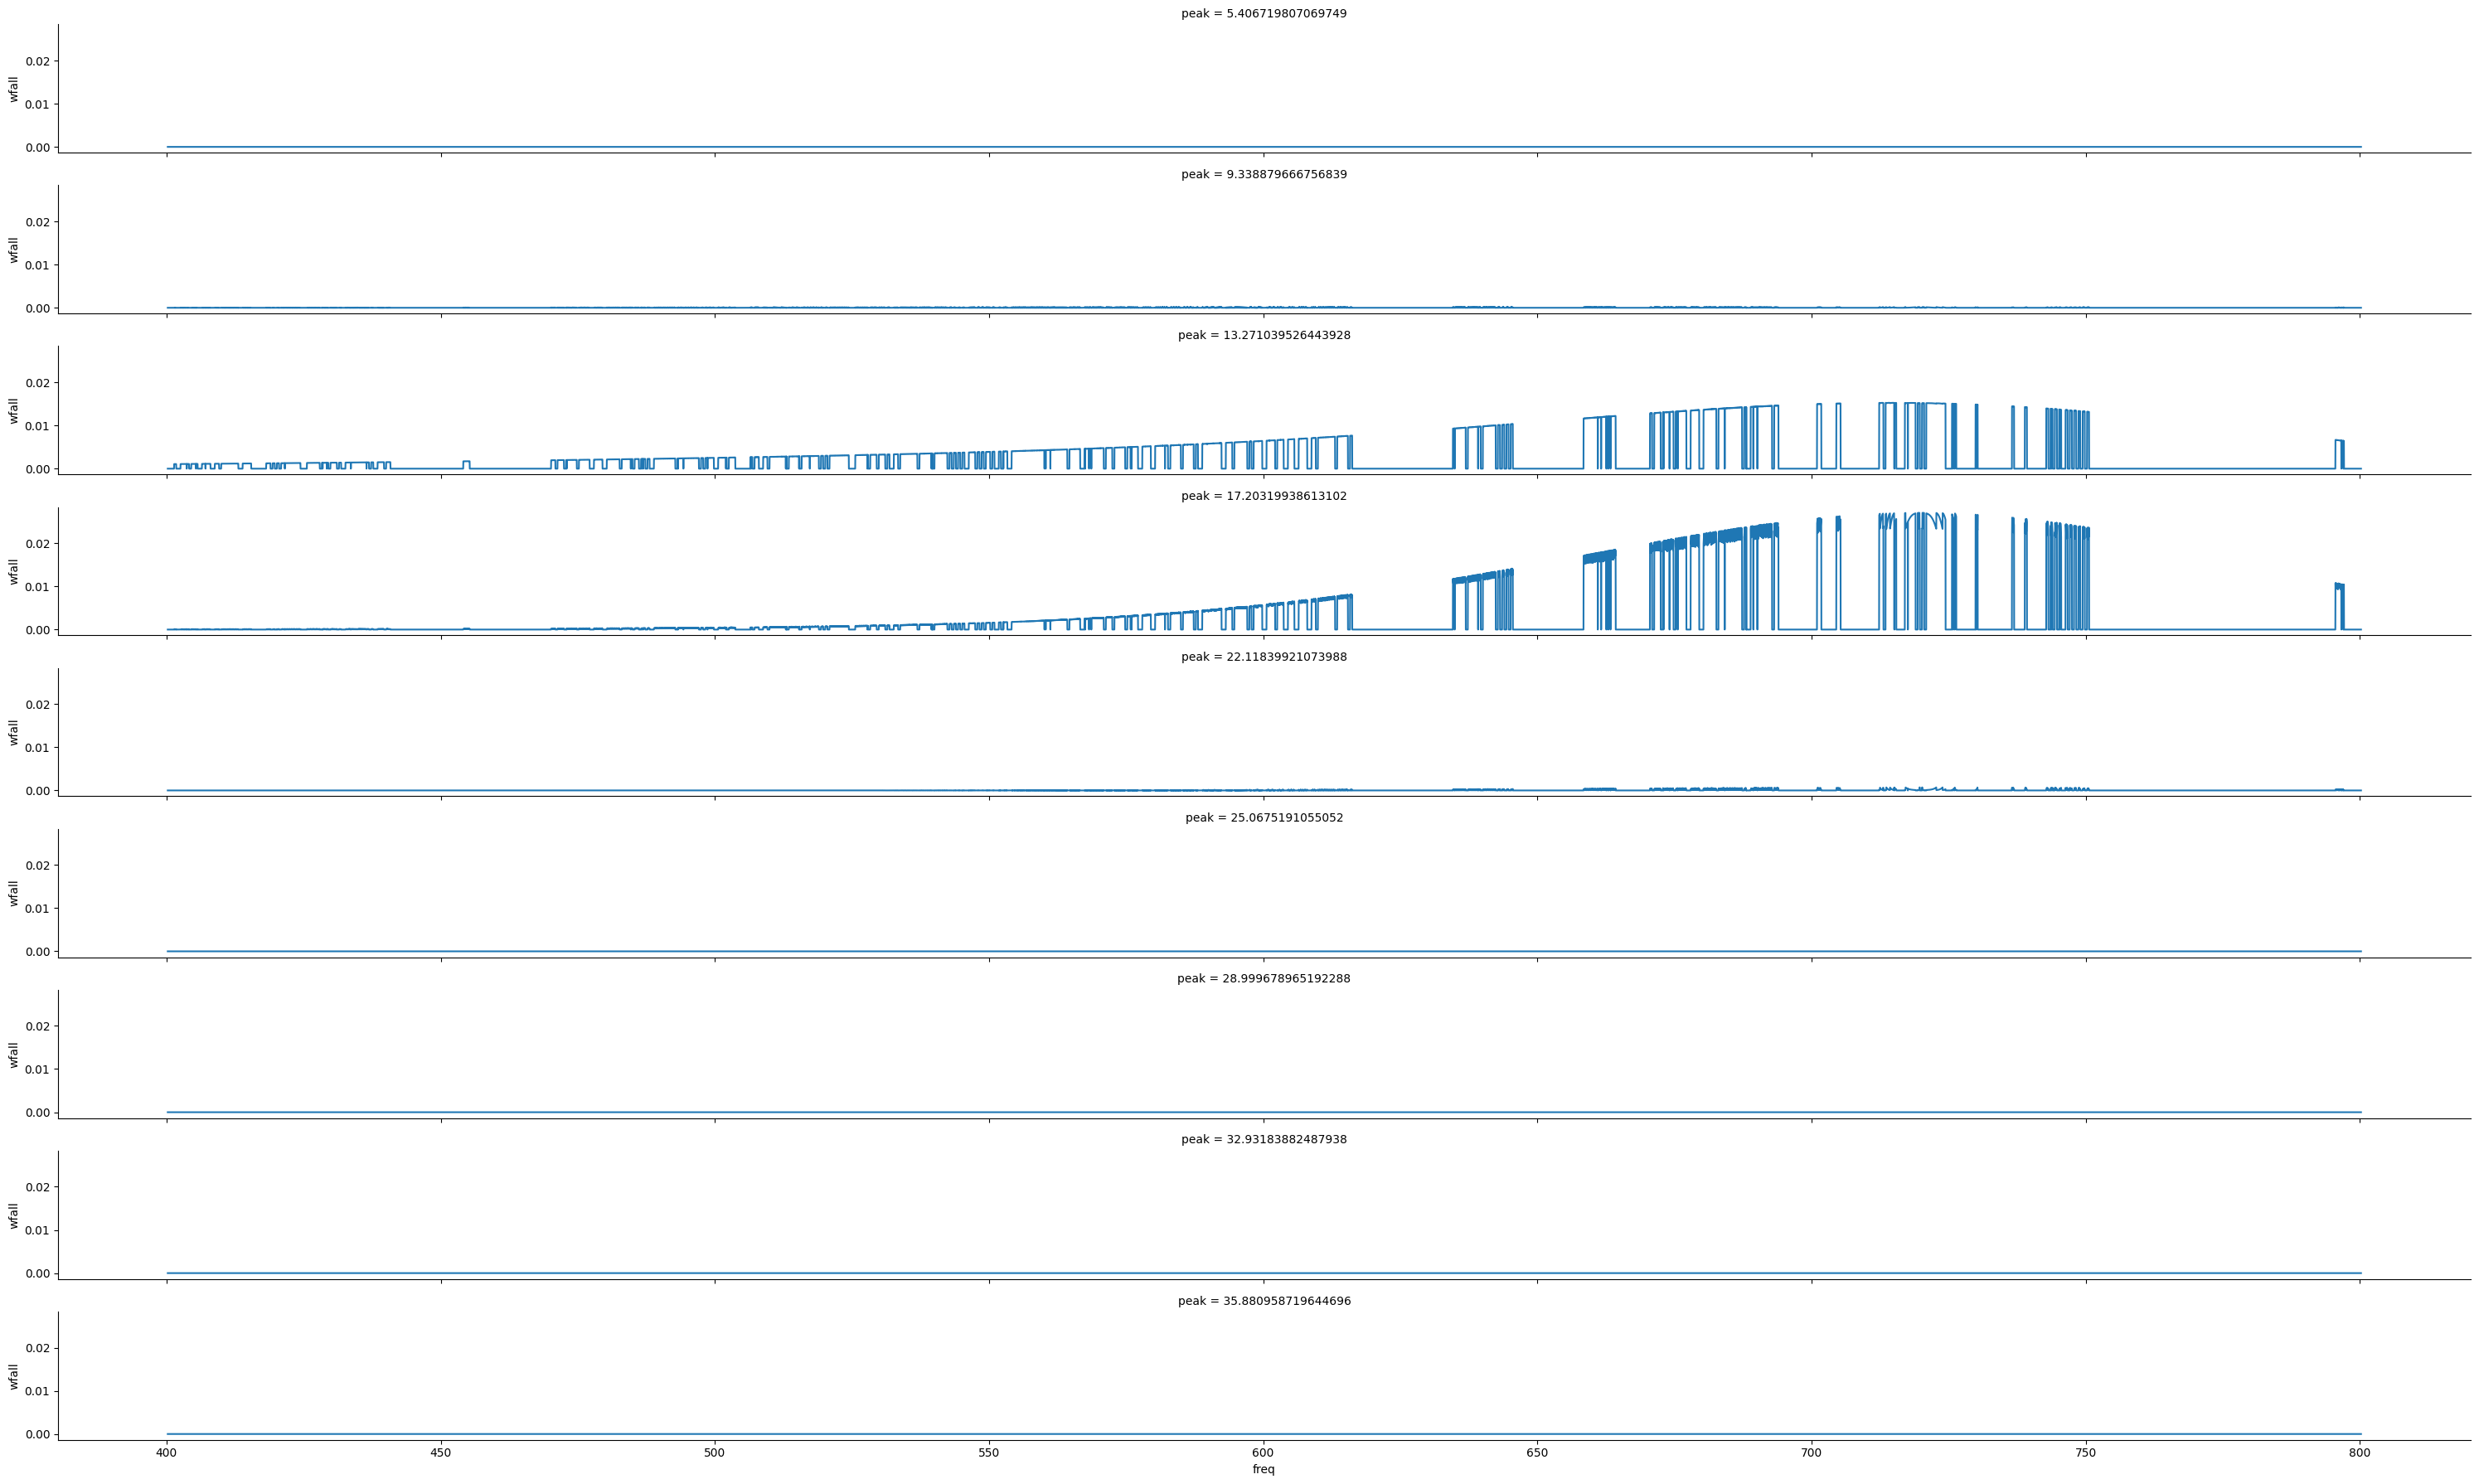

In [76]:
import seaborn as sns
# TODO Select around the peaks OR select around the burst?
# TODO Systematic FWTM
# TODO OR should we just use high_freq and low_freq from CHIME/FRB?
# data = pd.DataFrame.from_dict({"peak": burst.plot_time[peaks[0]], "freq": burst.plot_freq, "wfall": np.transpose(burst.model_wfall)[peaks[0]]})
data = pd.DataFrame()
for peak, left, right in zip(peaks, lefts, rights):
    new = pd.DataFrame({"peak": burst.plot_time[peak], "freq": burst.plot_freq, "wfall": np.nanmean(np.transpose(burst.model_wfall)[int(left):int(right)+1], axis=0)})
    _,_, leftborder, rightborder = find_full_width_nth_maximum(
            new['wfall'], [new['wfall'].to_numpy().argmax()], n=10
        )
    data = pd.concat([data, new])
    data.loc[data['peak'] == burst.plot_time[peak], "left"] = leftborder[0]
    data.loc[data['peak'] == burst.plot_time[peak], "right"] = rightborder[0]
g = sns.FacetGrid(data, row='peak', aspect=15, height=2)
g.map(sns.lineplot, 'freq', 'wfall')

<AxesSubplot: >

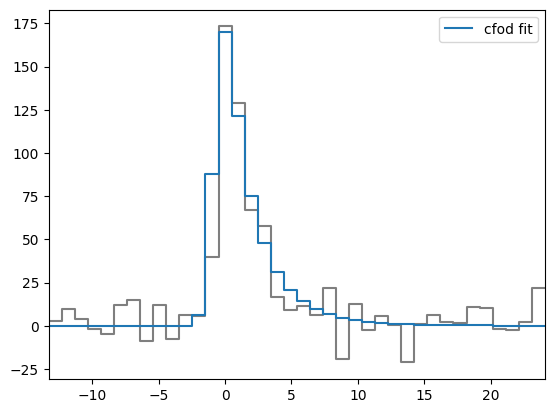

In [19]:
from sarjana.plotting import plot_time_flux
from sarjana.signal import is_multipeak

is_multipeak(burst.ts, prominence='stdev')
plot_time_flux(burst.ts, burst.model_ts, burst.plot_time, burst.dt)

In [158]:
from pathlib import Path
from sarjana.signal import is_multipeak, find_full_width_nth_maximum

catalog_file = Path('D://', 'home', 'datasets', 'sarjana', 'raw', 'cfod', 'chimefrb_profile_norfi.parquet')

catalog = pd.read_parquet(catalog_file)

# Resize time
catalog['plot_time'] = catalog['plot_time'] - (catalog['dt'] / 2)

catalog["multipeak"] = [is_multipeak(x.copy()) for x in catalog["ts"].values]
single_peaks = catalog[catalog["multipeak"] == False]
def time_width(flux, peaks, delta):
    widths, width_heights, lefts, rights = find_full_width_nth_maximum(
            flux, peaks, n=10
    )
    return widths[0]*delta
single_peaks['time_width'] = single_peaks.apply(lambda x: time_width(x['ts'].copy(), [x['ts'].argmax()], x['dt']), axis='columns')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17280\2230365237.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_peaks['time_width'] = single_peaks.apply(lambda x: time_width(x['ts'].copy(), [x['ts'].argmax()], x['dt']), axis='columns')


In [8]:
def gauss(time: np.ndarray, sigma: float, amplitude: float = 1.0, peak_time: float = 0.0):
    return amplitude * np.exp(-((time - peak_time) ** 2) / (2 * sigma**2))

def scattered_gaussian_signal(
    time: np.ndarray,
    sigma: float,
    tau: float,
    amplitude: float = 1.0,
    peak_time: float = 0.0,
) -> np.ndarray:
    _time = time - peak_time
    first_term: np.ndarray = -(_time / tau) + (sigma**2) / (2 * (tau**2))
    second_term: np.ndarray = (_time / (np.sqrt(2) * sigma)) - (
        sigma / (np.sqrt(2) * tau)
    )
    return amplitude * 0.5 * np.exp(first_term) * (1 + scipy.special.erf(second_term))

from typing import Callable
from sarjana.optimize import fit_time_series

def generate_single_peak_model(data: pd.DataFrame, func: Callable) -> pd.DataFrame:
    def try_fit(func, data) -> dict:
        try:
            return fit_time_series(
                func,
                data["plot_time"],
                data["ts"],
                params={
                    "amplitude": data["ts"].max(),
                    "peak_time": data["plot_time"][data["ts"].argmax()],
                },
            )
        except RuntimeError:
            return fit_time_series(
                func,
                data["plot_time"],
                data["model_ts"],
                params={
                    "amplitude": data["model_ts"].max(),
                    "peak_time": data["plot_time"][data["model_ts"].argmax()],
                },
            )

    data[func.__name__] = data.apply(
        lambda x: try_fit(func, x), axis="columns"
    )
    return data

In [159]:
df1 = generate_single_peak_model(single_peaks, scattered_gaussian_signal)

data = df1[['eventname', 'dm', 'scattered_gaussian_signal', 'time_width']]
data['sigma']     = data['scattered_gaussian_signal'].apply(lambda x: x.get('sigma', 0)[0])
data['sigma_err'] = data['scattered_gaussian_signal'].apply(lambda x: x.get('sigma', 0)[1])
data['tau']       = data['scattered_gaussian_signal'].apply(lambda x: x.get('tau', 0)[0])
data['tau_err']   = data['scattered_gaussian_signal'].apply(lambda x: x.get('tau', 0)[1])
data['sigma_per_tau']       = data['sigma']/data['tau']

d:\home\lab\sarjana\.venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
D:\home\lab\sarjana\sarjana\optimize.py:27: RuntimeWarning: invalid value encountered in sqrt
  _stdevs = np.sqrt(np.diag(_pcov))
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17280\2956812042.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[func.__name__] = data.apply(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17280\215846776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [149]:
import os
chime_catalog = os.environ.get('catalog')
cat = pd.read_csv(chime_catalog)

In [78]:
cat.columns

Index(['tns_name', 'previous_name', 'repeater_name', 'ra', 'ra_err',
       'ra_notes', 'dec', 'dec_err', 'dec_notes', 'gl',
       ...
       'weight_fluence_error_m', 'weight', 'weight_error_p', 'weight_error_m',
       'weighted_logrhoA', 'weighted_logrhoA_error_p',
       'weighted_logrhoA_error_m', 'weighted_logrhoB',
       'weighted_logrhoB_error_p', 'weighted_logrhoB_error_m'],
      dtype='object', length=107)

In [160]:
stats = pd.merge(data, cat[['tns_name','high_freq', 'low_freq', 'peak_freq', 'dm_fitb', 'scat_time']], left_on='eventname', right_on='tns_name').drop(columns='tns_name')
stats['bandwidth'] = stats['high_freq'] - stats['low_freq']

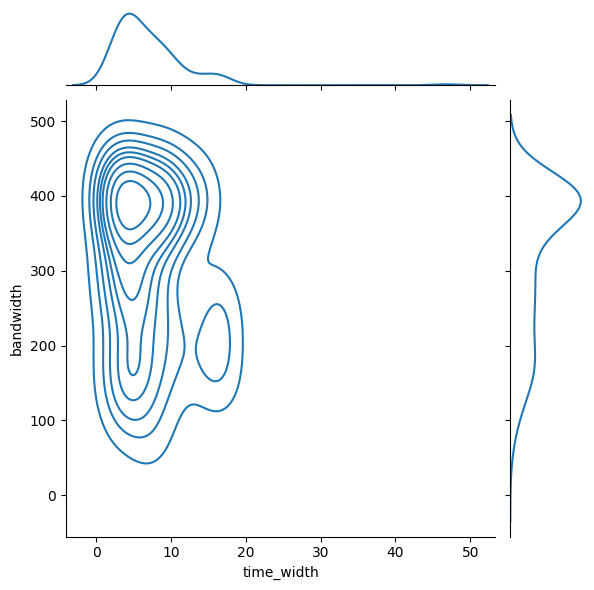

In [161]:
import seaborn as sns
sns.jointplot(stats, x='time_width',y='bandwidth', kind='kde')

In [201]:
from sklearn.cluster import KMeans

# DBSCAN is not helpful because many data are focused on the limit

clusterer = KMeans(n_clusters=2)
clusterer.fit(stats[['bandwidth']])
stats['label'] = clusterer.labels_

d:\home\lab\sarjana\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


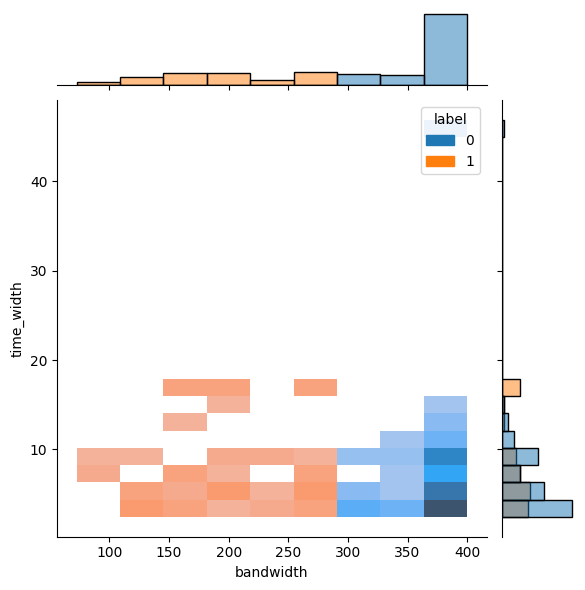

In [202]:
sns.jointplot(stats, x='bandwidth', y='time_width', hue='label', kind='hist')